### Twitter Sentiment Analysis

In [1]:
#!pip install wordcloud
#!pip install xgboost
#!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import html
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yuzij\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow import keras

### 0. Read in data
- Read in the data 'Sentiment.csv' and 'Canadian_election_2019.csv' as dataframes.
- Read in corpus as a list. Split words and sentiment in corpus.

In [4]:
election = pd.read_csv('Canadian_elections_2019.csv')
election.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"b""@RosieBarton So instead of your suggestion, ..."
1,Positive,NaN,"b""#AllWomanSpacewalk it's real!\n@Space_Statio..."
2,Negative,Economy,"b""#Brantford It's going to cost YOU $94 BILLIO..."
3,Positive,NaN,"b""#Canada #CanadaElection2019 #CanadaVotes \n#..."
4,Negative,Economy,"b""#Canada #taxpayers are sick &amp; tired of h..."


In [5]:
election['sentiment'].unique()

array(['Negative', 'Positive'], dtype=object)

In [6]:
tweets = pd.read_csv('Sentiment.csv')
tweets.head()

,sentiment,text
0,Positive,RT @Diplomtc_Immnty: @realDonaldTrump They tri...
1,Negative,"@chiefy74 Damn i'm jealous, i wanna watch the ..."
2,Positive,I'm listening The Beatles now. They're great
3,Positive,@ddlovato could i please get a shout out or an...
4,Positive,@salspizza just spotted ur message there Tony ...


Drop tweets with null.

In [0]:
tweets = tweets.dropna()

In [8]:
tweets['sentiment'].unique()

array(['Positive', 'Negative', 'Neutral'], dtype=object)

Notice that in 'Sentiment', the target values contain 'Positive', 'Negative', and 'Neutral'. Since there are no tweets labelled with 'Neutral' in 'Canadian_election_2019', we don't need 'Neutral' samples for training model. We drop 'Neutral' samples in 'Sentiment' dataset.

In [0]:
neu_index = tweets[tweets['sentiment']=='Neutral'].index
tweets = tweets.drop(neu_index)

### 1.Data cleaning
To make the dataset ready for NLP, we need to clean it by removing useless characters and information.<br>
1. Remove html tags and attributes.
2. Replace html character codes with an ASCII equivalent. 
3. Remove all URL links.
4. Lowercase all characters.
5. Remove all stopwords.

In [0]:
stopwords1 = stopwords.words('english')+['retweeted', 'b']
def clean_data(t):
    t = re.sub(r'<[^>]+>','', t) #remove html tags and attributes
    t = html.unescape(t)         #replace html codes with an ASCII equivalent
    t = re.sub(r'http\S+','', t)  #remove URL 
    t = t.lower()                #lowercase 
    t = re.sub(r'\\n', '', t) #remove new line handler \n
    t = re.sub(r'\\[a-zA-Z0-9]{0,19}','',t)
    t = re.sub(r'[^a-zA-Z]',' ',t)
    tokenizer = RegexpTokenizer(r'\w+')    #remove all punctuations     
    t = tokenizer.tokenize(t)
    
    t = [word for word in t if word not in stopwords1] # remove stop words
    #t = ' '.join(t)
    return t
    

First, let's clean tweets dataframe.

In [0]:
# clean tweets that are not 'nan'
text = tweets['text']
clean_text = text.apply(lambda x:clean_data(x))

In [12]:
tweets['text'] = clean_text
tweets.head()

,sentiment,text
0,Positive,"[rt, diplomtc, immnty, realdonaldtrump, tried,..."
1,Negative,"[chiefy, damn, jealous, wanna, watch, fight, l..."
2,Positive,"[listening, beatles, great]"
3,Positive,"[ddlovato, could, please, get, shout, anything..."
4,Positive,"[salspizza, spotted, ur, message, tony, replied]"


Then, do the same for election dataframe.

In [13]:
text = election['text']
clean_text = text.apply(lambda x:clean_data(x))
election['text'] = clean_text
election.head()

,sentiment,negative_reason,text
0,Negative,Women Reproductive right and Racism,"[rosiebarton, instead, suggestion, agree, cana..."
1,Positive,NaN,"[allwomanspacewalk, real, space, station, etob..."
2,Negative,Economy,"[brantford, going, cost, billion, next, years,..."
3,Positive,NaN,"[canada, canadaelection, canadavotes, elxn, de..."
4,Negative,Economy,"[canada, taxpayers, sick, tired, hard, earned,..."


### 2. Exploratory Analysis
To determine the political party of a given tweet, we need to find some keywords relating to political parties, such as candidate names and hashtag appearing on tweets. 

In [14]:
liberal = ['liberal', 'liberals', 'justin', 'trudeau', 'justintrudeau', 'trudeaumustgo', 'teamtrudeau','voteliberal']

conservative = ['conservative', 'conservatives', 'andrew', 'scheer', 'andrewscheer','andy']

ndp = ['ndp', 'democratic', 'jagmeet', 'singh']

pd = {'Liberal':liberal, 'Conservative':conservative, 'New Democratic Party':ndp}
party_dict = {}
for k,v in pd.items():
    for i in v:
        party_dict[i]=k
party_dict

{'andrew': 'Conservative',
 'andrewscheer': 'Conservative',
 'andy': 'Conservative',
 'conservative': 'Conservative',
 'conservatives': 'Conservative',
 'democratic': 'New Democratic Party',
 'jagmeet': 'New Democratic Party',
 'justin': 'Liberal',
 'justintrudeau': 'Liberal',
 'liberal': 'Liberal',
 'liberals': 'Liberal',
 'ndp': 'New Democratic Party',
 'scheer': 'Conservative',
 'singh': 'New Democratic Party',
 'teamtrudeau': 'Liberal',
 'trudeau': 'Liberal',
 'trudeaumustgo': 'Liberal',
 'voteliberal': 'Liberal'}

We assign a tweet to a party by the party which most words of the tweet are related to.

In [0]:
text = election['text']
party = []
for i in range(election.shape[0]):
    p = []
    for word in text[i]:
        if word in party_dict:
          p.append(party_dict[word])
    if len(p)>0:
      party.append(max(set(p), key=p.count))
    else:
      party.append('None')


The category 'None' we defined here includes all other parties except Liberal, Conservative and NDP. Therefore, 'None' does not necessarily mean the tweet has nothing to do with a specific party.

In [16]:
election['party']=party
election.head()

,sentiment,negative_reason,text,party
0,Negative,Women Reproductive right and Racism,"[rosiebarton, instead, suggestion, agree, cana...",Conservative
1,Positive,NaN,"[allwomanspacewalk, real, space, station, etob...",None
2,Negative,Economy,"[brantford, going, cost, billion, next, years,...",Liberal
3,Positive,NaN,"[canada, canadaelection, canadavotes, elxn, de...",None
4,Negative,Economy,"[canada, taxpayers, sick, tired, hard, earned,...",Liberal


Then, let's see distribution of parties of the election data.

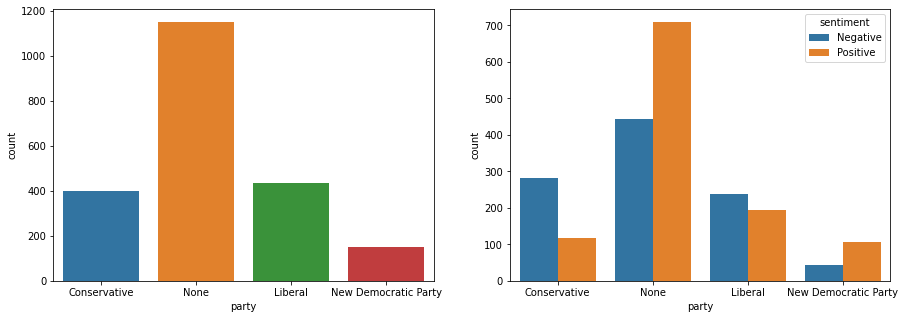

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='party', data=election, ax=ax1)
sns.countplot(x='party', hue = 'sentiment', data=election, ax=ax2)

- 'None' takes up the largest portion of total tweets, followed by Liberal and Conservative. Since there are many unidentified parties included in the 'None' category, we mainly focus on the positive and negative tweets of Liberal, Conservative and NDP to obtain useful information. <br>
- Liberal has the most positive tweets among the three parties. One thing we can notice is that new Democratic Party is the only party that has positive tweets more than negative tweets.


Then, let's visualize tweet content of 'Sentiment' data and 'Canadian_election' data.

Text(0.5, 1.0, 'Word cloud about Sentiment.csv')

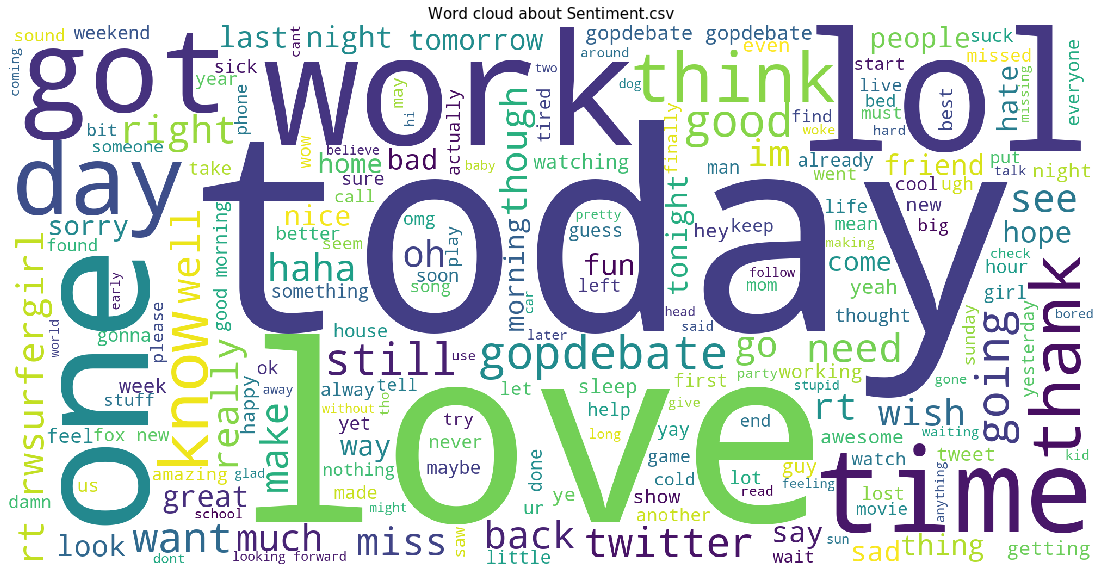

In [0]:
text = tweets['text'][tweets['text'].notnull()]
wordlist=[]
for t in text:
    for word in t:
        wordlist.append(word)

wordstring = ' '.join(wordlist)
wordcloud = WordCloud(width=2000, height=1000, background_color='white').generate(wordstring)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word cloud about Sentiment.csv', fontsize=15)

Text(0.5, 1.0, 'Word cloud about Canadian_elections_2019.csv')

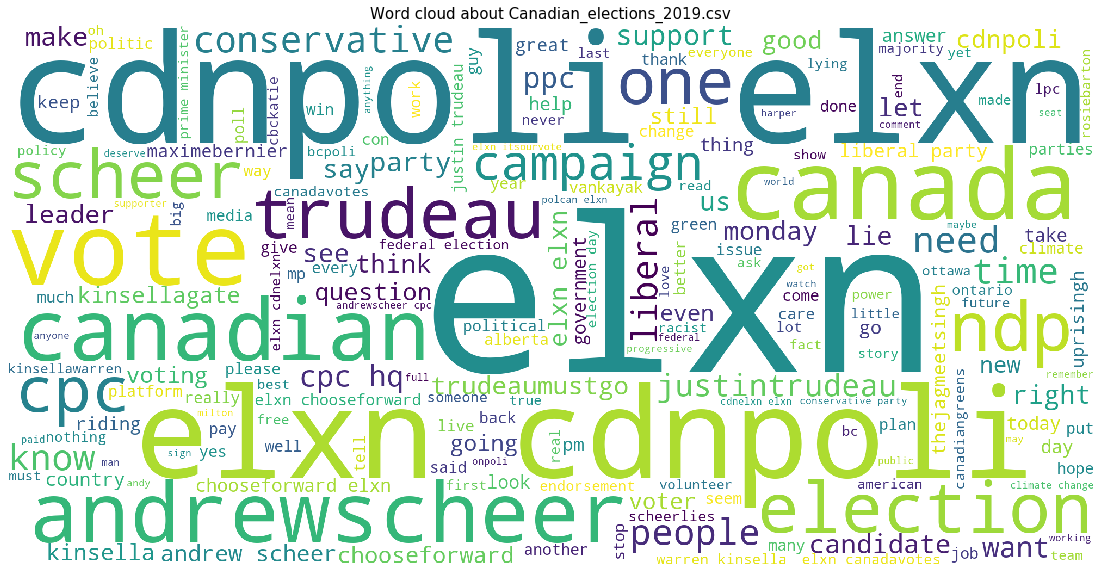

In [0]:
text = election['text'][election['text'].notnull()]
wordlist=[]
for t in text:
    for word in t:
        wordlist.append(word)

wordstring = ' '.join(wordlist)
wordcloud = WordCloud(width=2000, height=1000, background_color = 'white').generate(wordstring)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word cloud about Canadian_elections_2019.csv', fontsize=15)

### 3. Model Preparation
In this part, we need to prepare the 'Sentiment' data to try muliple classification algorithms, and we need to vectorize them.<br>
First, we split the 'Sentiment' into train set(70%) and test set(30%).

In [0]:
X = tweets['text']
y = tweets['sentiment']

We convert text content to vectors with word frequency (WF) which records the number of occurence of a word in a tweet.

In [0]:
X_list=[]

for i in list(X.index):
    t = ' '.join(X[i])
    X_list.append(t)

In [0]:
vectorizer = CountVectorizer(ngram_range=(1,5))
WF = vectorizer.fit_transform(X_list)
name = vectorizer.get_feature_names()

In [21]:
len(name)

2380675

Using all words doesn't help make accurate prediction. There are total more than 2 million distinct words in tweets of 'Sentiment' dataset. Most of the words may appear few times, and they contribute little to classification model. Besides, using all words will take much more time to train a model.<br>
We would like to pick the top 1000 words with high word frequency and use them to train a model.

In [0]:
matrix_freq = np.asarray(WF.sum(axis=0)).ravel()

In [23]:
matrix_freq.sort()
matrix_freq[-1000]

162

We pick the words with word frequency greater than or equal to 162.

In [0]:
name_freq = np.asarray(WF.sum(axis=0)).ravel()

In [0]:
final_matrix=[]
name_index=[]
for i in range(name_freq.shape[0]):
    if name_freq[i]>=162:
        final_matrix.append(WF[:,i])
        name_index.append(i)

In [26]:
len(name_index)

1010

There are 1010 words with word frequency >= 162. We will use the words and their frequencies to train a model.

In [0]:
final_name=[]
for i in name_index:
    final_name.append(name[i])

We would like to get new word frequency matrix and TF-IDF matrix with the final word name list we defined above.

In [0]:
pipe = Pipeline([('wf', CountVectorizer(vocabulary=final_name)),
                 ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True, norm=None))]).fit(X_list)

In [0]:
# convert to array
wf_array=pipe['wf'].transform(X_list).toarray()

In [0]:
# convert to array
tfidf_array=pipe.transform(X_list).toarray()

In [0]:
# convert to dataframe
import pandas as pd
wf_df = pd.DataFrame(data = wf_array, columns=final_name)
tfidf_df = pd.DataFrame(data = tfidf_array, columns=final_name)

### 4. Model implementation
#### 4.1 First model (predict sentiment)
- Now we encode sentiment with 1 and -1. 1 means the tweet is positive; -1 means the tweet is negative.
- We also split WF and Tfidf to training sets and test sets and apply models to see accuracy.<br>


In [0]:
code = {'Positive':1, 'Negative':-1}
y = y.replace(code)

In [0]:
# split word frequency dataframe
X_train_wf, X_test_wf, y_train_wf, y_test_wf = train_test_split(wf_df, y ,test_size=0.3, random_state=0)
# split tf-idf dataframe
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(tfidf_df, y ,test_size=0.3, random_state=0)

#### 4.1.1 Logistic Regression

Logistic regression is powerful in classification of "1/-1" target variable. Before training the model, input data should be scaled.

In [0]:
scaler = StandardScaler()
X_train_wf_s = scaler.fit_transform(X_train_wf)
X_test_wf_s = scaler.transform(X_test_wf)
X_train_t_s = scaler.fit_transform(X_train_t)
X_test_t_s = scaler.transform(X_test_t)

Then we tune hyperparameters C and solver. Training a logistic regression model takes some time, so we just do a rough tuning and then do a fine tuning if necessary.

In [35]:
# train the model with word frequency
print ('Word Frequency \n')
acc_lr_wf=[]
for c in [1, 10]:
    for solver in ['newton-cg','sag']:
        LR = LogisticRegression(C=c, solver=solver)
        LR.fit(X_train_wf_s, y_train_wf)
        
        acc_wf = LR.score(X_test_wf_s, y_test_wf)
        acc_lr_wf.append(acc_wf)
        print ('C =',c,', solver =', solver, ', accuracy =', round(acc_wf,3))

Word Frequency 

C = 1 , solver = newton-cg , accuracy = 0.74
C = 1 , solver = sag , accuracy = 0.74
C = 10 , solver = newton-cg , accuracy = 0.74
C = 10 , solver = sag , accuracy = 0.74


In [36]:
# train the model with tf-idf
print ('TF-IDF \n')
acc_lr_t=[]
for c in [1, 10]:
    for solver in ['newton-cg','sag']:
        LR = LogisticRegression(C=c, solver=solver)
        LR.fit(X_train_t_s, y_train_t)
        
        acc_t = LR.score(X_test_t_s, y_test_t)
        acc_lr_t.append(acc_t)
        print ('C =',c,', solver =', solver, ', accuracy =', round(acc_t,3))

TF-IDF 

C = 1 , solver = newton-cg , accuracy = 0.74
C = 1 , solver = sag , accuracy = 0.74
C = 10 , solver = newton-cg , accuracy = 0.74
C = 10 , solver = sag , accuracy = 0.74


Accuracies of logistic regression models are all above 0.7. Tuning hyperparameters doesn't improve accuracy in a noticeable scale.

#### 4.1.2 kNN

kNN is a useful algorithm in classfying multiple classes. Principle component analysis (PCA) is usually to reduce dimension of data and help kNN work more efficiently.

In [37]:
pca = PCA(n_components=10)
pc_train_wf = pca.fit_transform(X_train_wf_s)
pc_test_wf = pca.fit_transform(X_test_wf_s)
pc_train_t = pca.fit_transform(X_train_t_s)
pc_test_t = pca.fit_transform(X_test_t_s)
print (pca.explained_variance_ratio_[:10])

[0.00618179 0.00420429 0.00369726 0.00348425 0.00334536 0.00325707
 0.00281938 0.00239653 0.00226409 0.00214876]


- The explained variances of principle components are low. Applying principle components may not efficiently help knn since most feature variances are lost.<br>
- However, applying all features to knn classification slows down the model as the dimension is too high. Therefore, knn is not a good candidate model in this NLP project.
- The hyperparameter we can tune here is n, the number of neighbors the model needs to decide the class of a sample.

In [38]:
print ('Word Frequency \n')
acc_knn_wf=[]
for n in [10, 20, 30, 40]:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(pc_train_wf, y_train_wf)
  acc_wf = knn.score(pc_test_wf, y_test_wf)
  acc_knn_wf.append(acc_wf)
  print ('n = ', n, 'accuracy of kNN =', round(acc_wf,3))

Word Frequency 

n =  10 accuracy of kNN = 0.567
n =  20 accuracy of kNN = 0.574
n =  30 accuracy of kNN = 0.577
n =  40 accuracy of kNN = 0.579


In [39]:
print ('TF-IDF \n')
acc_knn_t=[]
for n in [10,20,30,40]:
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(pc_train_t, y_train_t)
  acc_t = knn.score(pc_test_t, y_test_t)
  acc_knn_t.append(acc_t)
  print ('n = ', n,' accuracy of kNN =', round(acc_t,3))

TF-IDF 

n =  10  accuracy of kNN = 0.547
n =  20  accuracy of kNN = 0.553
n =  30  accuracy of kNN = 0.557
n =  40  accuracy of kNN = 0.561


Accuracies of kNN models are generally between 0.5 and 0.55, which are lower than accuracies of logistic regression models.

#### 4.1.3 Naive Bayes

Naive Bayes methods are based on Bayes’ theorem with the “naive” assumption of conditional independence between every pair of features given the value of the class variable. <br>
Gaussian naive bayes is used here.

In [40]:
gnb = GaussianNB()
gnb.fit(X_train_wf, y_train_wf)
acc_nb_wf = gnb.score(X_test_wf, y_test_wf)
print ('WF: accuracy of Naive Bayes =', round(acc_nb_wf,3))

WF: accuracy of Naive Bayes = 0.67


In [41]:
gnb.fit(X_train_t, y_train_t)
acc_nb_t = gnb.score(X_test_t, y_test_t)
print ('tfidf: accuracy of Naive Bayes =', round(acc_nb_t,3))

tfidf: accuracy of Naive Bayes = 0.67


Accuracis of naive bayes models are 0.67 for word frequency and tf-idf.

#### 4.1.4 Decision trees

Decision tree is a supervised learing algorithm that predicts target variable by learning simple decision rules from data features. One advantage is that it requires little data preparation. It doesn't require scaling which is necessary for logistic regression.<br>
We can tune 'max_depth' of a decision tree.

In [42]:
print ('Word Frequency')
acc_dt_wf=[]
for i in [20, 40, 60, 80]:
    dt = DecisionTreeClassifier(max_depth=i, random_state=0)
    dt.fit(X_train_wf, y_train_wf)
    acc_wf = dt.score(X_test_wf, y_test_wf)
    acc_dt_wf.append(acc_wf)
    print ('max depth =',i, ', accuracy =', round(acc_wf,3))

Word Frequency
max depth = 20 , accuracy = 0.618
max depth = 40 , accuracy = 0.637
max depth = 60 , accuracy = 0.655
max depth = 80 , accuracy = 0.662


In [43]:
print ('TF-IDF')
acc_dt_t=[]
for i in [20, 40, 60, 80]:
    dt = DecisionTreeClassifier(max_depth=i, random_state=0)
    dt.fit(X_train_t, y_train_t)
    acc_t = dt.score(X_test_t, y_test_t)
    acc_dt_t.append(acc_t)
    print ('max depth =', i,', accuracy =', round(acc_t,3))

TF-IDF
max depth = 20 , accuracy = 0.618
max depth = 40 , accuracy = 0.637
max depth = 60 , accuracy = 0.655
max depth = 80 , accuracy = 0.662


The accuracies are between 0.6 and 0.7, which are lower than accuracies of logistic regression models. Accuracy increases with max depth. There is no obvious difference between accuracies obtained by models with word frequency and tf-idf.

#### 4.1.5 Ensemble:Random forest

A random forest is a ensemble method that fits a number of decision trees on various sub-samples of the dataset. By averaging, a random forest improves accuracy and controls over-fitting. <br>
Here we tune hyperparameters 'max_depth' and 'min_samples_split'. 
- 'Max_depth' is the maximum depth of a tree. 
- 'Min_samples_split' is the minimum number of samples required to split an internal node.

In [44]:
print ('Word Frequency')
acc_rf_wf=[]
for i in [20, 40]:
  for j in [10, 20]:
    rf = RandomForestClassifier(max_depth=i, min_samples_split=j, random_state=0)
    rf.fit(X_train_wf, y_train_wf)
    acc_wf = rf.score(X_test_wf, y_test_wf)
    acc_rf_wf.append(acc_wf)
    print ('max depth =', i, 'min samples split = ', j, 'accuracy =', round(acc_wf,3))

Word Frequency
max depth = 20 min samples split =  10 accuracy = 0.669
max depth = 20 min samples split =  20 accuracy = 0.67
max depth = 40 min samples split =  10 accuracy = 0.692
max depth = 40 min samples split =  20 accuracy = 0.692


In [45]:
print ('TF-IDF')
acc_rf_t=[]
for i in [20, 40]:
  for j in [10, 20]:
    rf = RandomForestClassifier(max_depth=i, min_samples_split=j, random_state=0)
    rf.fit(X_train_t, y_train_t)
    acc_t = rf.score(X_test_t, y_test_t)
    acc_rf_t.append(acc_t)
    print ('max depth =', i, 'min samples split', j, 'accuracy =', round(acc_t,3))

TF-IDF
max depth = 20 min samples split 10 accuracy = 0.669
max depth = 20 min samples split 20 accuracy = 0.67
max depth = 40 min samples split 10 accuracy = 0.692
max depth = 40 min samples split 20 accuracy = 0.692


The accuracies are between 0.65 and 0.7, which are generally higher than accuracies of decision tree models but still lower than logistic regression models.

#### 4.1.6 Ensemble: Gradient boosting

XGboost is based on the idea that we build a strong model by learning from conclusions drawn by a weak model. The base learner of XGboost is tree ensembles, which is a set of classification and regression trees.<br>
We can tune hyperparameter 'learning_rate' of XGboost. 


In [46]:
print ('Word Frequency')
acc_xgb_wf=[]
for i in [0.01, 0.1, 1, 2]:
    xg_reg = xgb.XGBClassifier(objective='reg:logistic', learning_rate = i)
    xg_reg.fit(X_train_wf,y_train_wf)

    preds = xg_reg.predict(X_test_wf)
    acc_wf = accuracy_score(y_test_wf, preds)
    acc_xgb_wf.append(acc_wf)
    print ('learning rate =', i,', accuracy =', round(acc_wf,3))

Word Frequency
learning rate = 0.01 , accuracy = 0.6
learning rate = 0.1 , accuracy = 0.665
learning rate = 1 , accuracy = 0.732
learning rate = 2 , accuracy = 0.55


In [47]:
print ('TF-IDF')
acc_xgb_t=[]
for i in [0.01, 0.1, 1, 2]:
    xg_reg = xgb.XGBClassifier(objective='reg:logistic', learning_rate = i)
    xg_reg.fit(X_train_t,y_train_t)

    preds = xg_reg.predict(X_test_t)
    acc_t = accuracy_score(y_test_t, preds)
    acc_xgb_t.append(acc_t)
    print ('learning rate =', i,', accuracy =', round(acc_t,3))

TF-IDF
learning rate = 0.01 , accuracy = 0.6
learning rate = 0.1 , accuracy = 0.665
learning rate = 1 , accuracy = 0.732
learning rate = 2 , accuracy = 0.55


#### 4.1.7 Compare models
Then we draw graphs to visualize performance of different algorithms in prediction of sentiment.

Text(0.5, 1.0, 'Accuracy of TF-IDF feature')

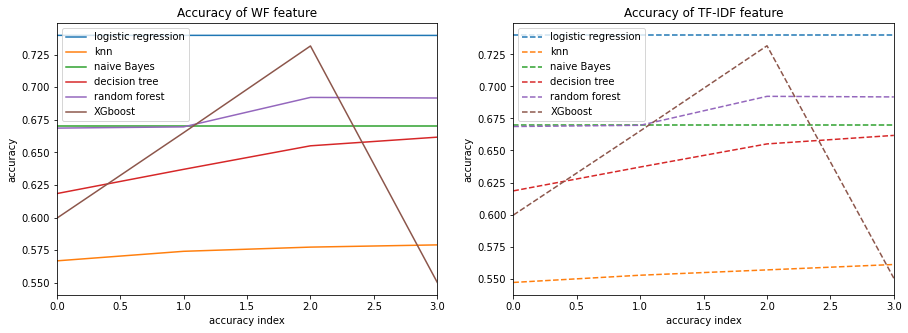

In [48]:
fig = plt.subplots(1,2,figsize=(15,5))
plt.subplot(1,2,1)
acc_nb_ = acc_nb_wf*np.ones(4)
plt.plot(acc_lr_wf, '-', label='logistic regression')
plt.plot(acc_knn_wf, '-', label='knn')
plt.plot(acc_nb_, '-',label='naive Bayes')
plt.plot(acc_dt_wf, '-', label='decision tree')
plt.plot(acc_rf_wf, '-', label='random forest')
plt.plot(acc_xgb_wf, '-', label='XGboost')
plt.legend()
plt.xlim(0,3)
plt.xlabel('accuracy index')
plt.ylabel('accuracy')
plt.title('Accuracy of WF feature')


plt.subplot(1,2, 2)
acc_nb = acc_nb_t*np.ones(4)
plt.plot(acc_lr_t, '--', label='logistic regression')
plt.plot(acc_knn_t, '--', label='knn')
plt.plot(acc_nb, '--',label='naive Bayes')
plt.plot(acc_dt_t, '--', label='decision tree')
plt.plot(acc_rf_t, '--', label='random forest')
plt.plot(acc_xgb_t, '--', label='XGboost')
plt.legend()
plt.xlim(0,3)
plt.xlabel("accuracy index")
plt.ylabel('accuracy')
plt.title('Accuracy of TF-IDF feature')


The above two graphs look almost the same. Prediction with TF-IDF feature is generally a little better than prediction with WF feature in terms of accuracy value except for logistic regression. Logistic regression accuracy is around 0.74 with varying hyperparameters, which is the highest value among accuracies of all models. <br>
#### 4.1.8 Apply best model to election data
As a result, logistic regression model with WF feature of tweets is the best model that has the highest accuracy. We tune hyperparameters C and solver of logistic regression to try to increase accuracy.

In [0]:
acc_list=[]
for solver in ['newton-cg','lbfgs','sag','saga']:
  acc=[]
  for c in [0.001, 0.01, 0.1, 1, 10]:  
    LR = LogisticRegression(C=c, solver=solver)
    LR.fit(X_train_wf_s, y_train_wf)
    acc_wf = LR.score(X_test_wf_s, y_test_wf)
    acc.append(acc_wf)
  acc_list.append(acc)


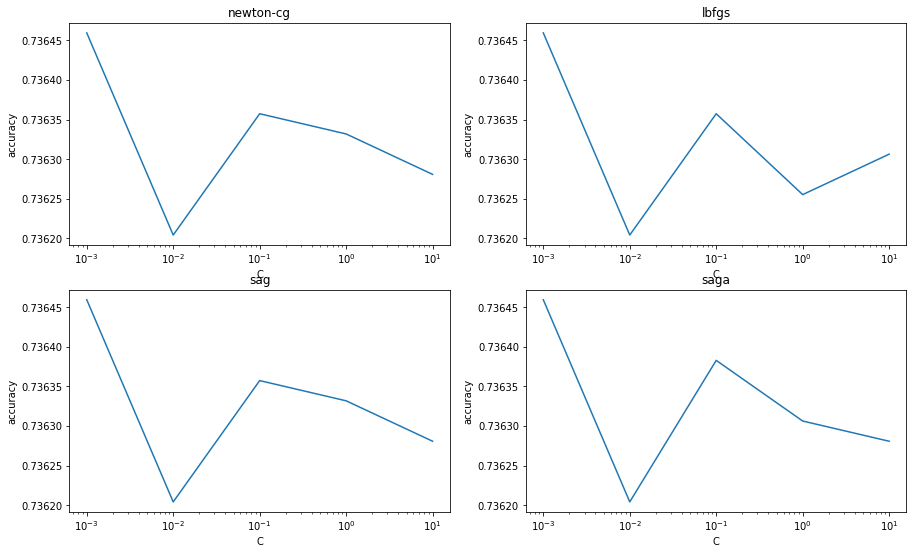

In [0]:
C=[0.001, 0.01, 0.1, 1, 10]
solver=['newton-cg','lbfgs','sag','saga']
fig = plt.subplots(2,2, figsize=(15,9))
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.plot(C, acc_list[i])
  plt.semilogx()
  plt.title(solver[i])
  plt.ylabel('accuracy')
  plt.xlabel('C')

Tuning hyperparameters of logistic regression does not increase accuracy in a noticable scale. We can use C=0.1 and solver='newton-cg' and apply the model to predict 2019 election data.<br>
First, we need to transform election text to word frequency.

In [0]:
X = election['text']
y = election['sentiment']

In [0]:
X_list=[]

for i in list(X.index):
    t = ' '.join(X[i])
    X_list.append(t)

We use the same word list as we used in generating word frequency array of 'Sentiment' to generate WF array of 'Canadian_election_2019', so that we can apply the model trained by 'Sentiment' data to predict sentiment of 'Canadian_election_2019' tweets.

In [0]:
pipe = Pipeline([('wf', CountVectorizer(vocabulary=final_name)),
                 ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True, norm=None))]).fit(X_list)

In [0]:
wf_array=pipe['wf'].transform(X_list).toarray()
tfidf_array=pipe.transform(X_list).toarray()

In [0]:
code = {'Positive':1, 'Negative':-1}
y = y.replace(code)

Now we apply logistic regression on election data.

In [40]:
X_s = scaler.fit_transform(wf_array)
lr = LogisticRegression(C=0.1,solver='newton-cg')
lr.fit(X_train_wf_s, y_train_wf)
y_pred = lr.predict(X_s)
print ('accuracy:',round(lr.score(X_s, y),3))

accuracy: 0.556


In [55]:
from sklearn.metrics import classification_report
print(classification_report(y, y_pred,target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.52      0.74      0.61      1006
    Positive       0.63      0.39      0.48      1127

    accuracy                           0.56      2133
   macro avg       0.57      0.57      0.55      2133
weighted avg       0.58      0.56      0.54      2133



- The same model has a 0.74 accuracy on 'Sentiment' while only 0.556 accuracy on 'Canadian_election'. 
- The model prediction gives higher precision score on 'Positive' and higher recall score on 'Negative' sentiment.

Plot prediction results in terms of true sentiment of tweets

In [0]:
election['prediction']=y_pred
decode = {1:'Positive', -1:'Negative'}
election = election.replace(decode)

In [0]:
election_positive=election[election['sentiment']=='Positive']
election_negative=election[election['sentiment']=='Negative']

[Text(0.5, 0, 'True sentiment'), Text(0.5, 1.0, 'New Democratic Party')]

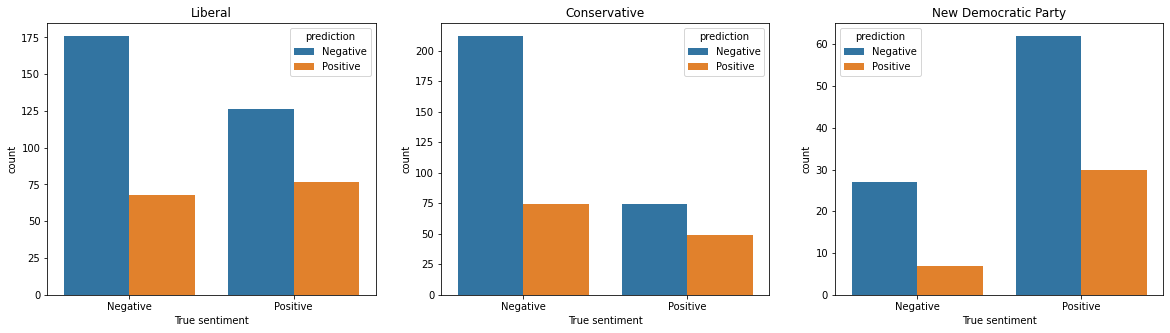

In [59]:
fig1, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
l_plot = sns.countplot(x='sentiment', hue = 'prediction', hue_order=['Negative','Positive'], data=election[election.party=='Liberal'], ax=ax1)
l_plot.set(xlabel='True sentiment', title='Liberal')

c_plot = sns.countplot(x='sentiment', hue = 'prediction', data=election[election.party=='Conservative'], ax=ax2)
c_plot.set(xlabel='True sentiment', title='Conservative')

n_plot = sns.countplot(x='sentiment', hue = 'prediction', data=election[election.party=='New Democratic Party'], ax=ax3)
n_plot.set(xlabel='True sentiment', title='New Democratic Party')


- As illustrated in the plots above, most tweets are predicted to be negative for each party. <br>
- Liberal won the 2019 election. Assuming more positive tweets means higher probability to win. NLP analytics give similar percentages of tweets predicted to be positive and negative for each of the three parties, and it doesn't tell which party is more likely to win. One thing the three parties all know is that there are more negative tweets about them rather than positive tweets.
- In a word, NLP analytics based on tweets is not useful for political parties during election compaigns. 

#### 4.2 Second model (predict negative reason)

In [61]:
print ('total tweets:', election_negative.shape[0])

total tweets: 1006


In [62]:
election_negative['negative_reason'].value_counts()

Others                                 364
Scandal                                270
Tell lies                              198
Economy                                 51
Women Reproductive right and Racism     45
Climate Problem                         41
Separation                              16
Privilege                               12
Healthcare                               5
Healthcare and Marijuana                 4
Name: negative_reason, dtype: int64

For negative reason 'Healthcare', and 'Healthcare and Marijuana', they both are related to health. Besides, relevant tweets for each of them are less than 1% of total election tweets. We may not predict the reasons well due to a small number of available training samples. Therefore, the two reasons are combined together.

We can encode reasons by integers since they are categorical feature.

In [0]:
reason_code={'Others':1,
             'Separation':7, 
             'Privilege':8,
             'Healthcare':9,
             'Healthcare and Marijuana':9,
             'Scandal':2,
             'Tell lies':3,
             'Economy':4,
             'Women Reproductive right and Racism':5,
             'Climate Problem':6}

In [0]:
election_negative=election_negative.replace(reason_code)

Create word frequency feature and tf-idf feature of negative tweets.

In [0]:
X = election_negative['text']
y = election_negative['negative_reason']
X_list=[]

for i in list(X.index):
    t = ' '.join(X[i])
    X_list.append(t)

In [0]:
vectorizer = CountVectorizer(ngram_range=(1,5))
WF = vectorizer.fit_transform(X_list)
name = vectorizer.get_feature_names()

We pick the top 300 words with high word frequency and use the words to create word frequency feature and tf-idf feature.

In [59]:
matrix_freq = np.asarray(WF.sum(axis=0)).ravel()
matrix_freq.sort()
matrix_freq[-300]

11

In [60]:
name_freq = np.asarray(WF.sum(axis=0)).ravel()
name_index=[]
for i in range(name_freq.shape[0]):
    if name_freq[i]>=11:
      final_matrix.append(WF[:,i])
      name_index.append(i)
len(name_index)

300

In [0]:
final_name=[]
for i in name_index:
    final_name.append(name[i])
pipe = Pipeline([('wf', CountVectorizer(vocabulary=final_name)),
                 ('tfidf', TfidfTransformer(use_idf=True, smooth_idf=True, norm=None))]).fit(X_list)

In [0]:
wf_array=pipe['wf'].transform(X_list).toarray()
tfidf_array=pipe.transform(X_list).toarray()
import pandas as pd
wf_df = pd.DataFrame(data = wf_array, columns=final_name)
tfidf_df = pd.DataFrame(data = tfidf_array, columns=final_name)

Split the data to training set and test set.

In [0]:
X_train_wf, X_test_wf, y_train_wf, y_test_wf = train_test_split(wf_df, y ,test_size=0.3, random_state=0)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(tfidf_df, y ,test_size=0.3, random_state=0)

#### 4.2.1 kNN

Use PCA to for dimension reduction before applying kNN.

In [0]:
X_train_wf_s = scaler.fit_transform(X_train_wf)
X_test_wf_s = scaler.transform(X_test_wf)
X_train_t_s = scaler.fit_transform(X_train_t)
X_test_t_s = scaler.transform(X_test_t)

In [73]:
pca = PCA(n_components=20)
pc_train_wf = pca.fit_transform(X_train_wf_s)
pc_test_wf = pca.fit_transform(X_test_wf_s)
pc_train_t = pca.fit_transform(X_train_t_s)
pc_test_t = pca.fit_transform(X_test_t_s)
print (sum(pca.explained_variance_ratio_[:20]))

0.3200548402661152


The sum of explained variance of the first 20 components is 0.32, indicating that most variance is lost and the model performance may not be satisfying.

In [74]:
print ('Word Frequency \n')
acc_knn_wf=[]
for n in np.arange(1,11):
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(pc_train_wf, y_train_wf)
  acc_wf = knn.score(pc_test_wf, y_test_wf)
  acc_knn_wf.append(acc_wf)
  print ('n = ', n, 'accuracy of kNN =', round(acc_wf,3))

Word Frequency 

n =  1 accuracy of kNN = 0.248
n =  2 accuracy of kNN = 0.344
n =  3 accuracy of kNN = 0.301
n =  4 accuracy of kNN = 0.328
n =  5 accuracy of kNN = 0.328
n =  6 accuracy of kNN = 0.354
n =  7 accuracy of kNN = 0.358
n =  8 accuracy of kNN = 0.354
n =  9 accuracy of kNN = 0.384
n =  10 accuracy of kNN = 0.371


In [75]:
print ('TF-IDF \n')
acc_knn_t=[]
for n in np.arange(1,11):
  knn = KNeighborsClassifier(n_neighbors=n)
  knn.fit(pc_train_t, y_train_t)
  acc_t = knn.score(pc_test_t, y_test_t)
  acc_knn_t.append(acc_t)
  print ('n = ', n,' accuracy of kNN =', round(acc_t,3))

TF-IDF 

n =  1  accuracy of kNN = 0.195
n =  2  accuracy of kNN = 0.334
n =  3  accuracy of kNN = 0.308
n =  4  accuracy of kNN = 0.315
n =  5  accuracy of kNN = 0.305
n =  6  accuracy of kNN = 0.301
n =  7  accuracy of kNN = 0.262
n =  8  accuracy of kNN = 0.305
n =  9  accuracy of kNN = 0.308
n =  10  accuracy of kNN = 0.328


Generally, the accuracy is between 3 and 4. The accuracy obtained with word frequency feature is higher than tf-idf feature for the same n.

#### 4.2.2 Random forest

In [76]:
print ('Word Frequency')
acc_rf_wf=[]
for i in np.arange(10,110,10):
  rf = RandomForestClassifier(max_depth=i, random_state=0)
  rf.fit(X_train_wf, y_train_wf)
  acc_wf = rf.score(X_test_wf, y_test_wf)
  acc_rf_wf.append(acc_wf)
  print ('max depth =', i, 'accuracy =', round(acc_wf,3))

Word Frequency
max depth = 10 accuracy = 0.543
max depth = 20 accuracy = 0.583
max depth = 30 accuracy = 0.609
max depth = 40 accuracy = 0.589
max depth = 50 accuracy = 0.593
max depth = 60 accuracy = 0.579
max depth = 70 accuracy = 0.576
max depth = 80 accuracy = 0.576
max depth = 90 accuracy = 0.573
max depth = 100 accuracy = 0.57


In [77]:
print ('TF-IDF')
acc_rf_t=[]
for i in np.arange(10,110,10):
  rf = RandomForestClassifier(max_depth=i, random_state=0)
  rf.fit(X_train_t, y_train_t)
  acc_t = rf.score(X_test_t, y_test_t)
  acc_rf_t.append(acc_t)
  print ('max depth =', i, 'accuracy =', round(acc_t,3))

TF-IDF
max depth = 10 accuracy = 0.543
max depth = 20 accuracy = 0.583
max depth = 30 accuracy = 0.609
max depth = 40 accuracy = 0.589
max depth = 50 accuracy = 0.593
max depth = 60 accuracy = 0.579
max depth = 70 accuracy = 0.576
max depth = 80 accuracy = 0.576
max depth = 90 accuracy = 0.573
max depth = 100 accuracy = 0.573


The accuracy is around 0.58. There is almost no difference between accuracies obtained with word frequency feature and tf-idf feature.

#### 4.2.3 Decision tree

In [78]:
print ('Word Frequency')
acc_dt_wf=[]
for i in np.arange(10,110,10):
    dt = DecisionTreeClassifier(max_depth=i, random_state=0)
    dt.fit(X_train_wf, y_train_wf)
    acc_wf = dt.score(X_test_wf, y_test_wf)
    acc_dt_wf.append(acc_wf)
    print ('max depth =',i, ', accuracy =', round(acc_wf,3))

Word Frequency
max depth = 10 , accuracy = 0.556
max depth = 20 , accuracy = 0.57
max depth = 30 , accuracy = 0.566
max depth = 40 , accuracy = 0.566
max depth = 50 , accuracy = 0.526
max depth = 60 , accuracy = 0.543
max depth = 70 , accuracy = 0.536
max depth = 80 , accuracy = 0.517
max depth = 90 , accuracy = 0.52
max depth = 100 , accuracy = 0.53


In [79]:
print ('TF-IDF')
acc_dt_t=[]
for i in np.arange(10,110,10):
    dt = DecisionTreeClassifier(max_depth=i, random_state=0)
    dt.fit(X_train_t, y_train_t)
    acc_t = dt.score(X_test_t, y_test_t)
    acc_dt_t.append(acc_t)
    print ('max depth =', i,', accuracy =', round(acc_t,3))

TF-IDF
max depth = 10 , accuracy = 0.556
max depth = 20 , accuracy = 0.57
max depth = 30 , accuracy = 0.566
max depth = 40 , accuracy = 0.566
max depth = 50 , accuracy = 0.526
max depth = 60 , accuracy = 0.543
max depth = 70 , accuracy = 0.536
max depth = 80 , accuracy = 0.517
max depth = 90 , accuracy = 0.52
max depth = 100 , accuracy = 0.53


The accuracy is around 0.55. Word frequency and tf-idf features don't make a difference.
#### 4.2.4 Compare models

Text(0.5, 1.0, 'Accuracy')

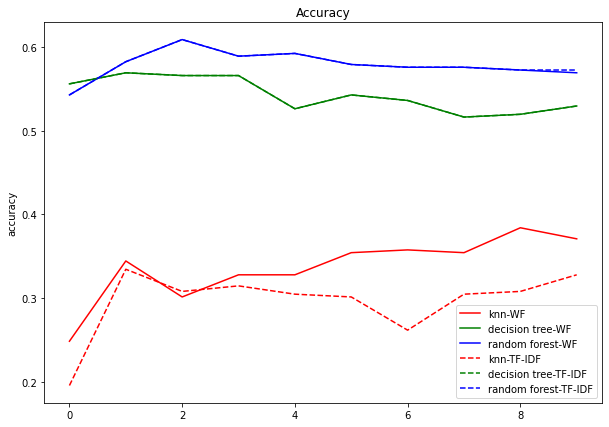

In [80]:
fig = plt.figure(figsize=(10,7))
plt.plot(acc_knn_wf, color='r', linestyle='-', label='knn-WF')
plt.plot(acc_dt_wf, color='g', linestyle='-', label='decision tree-WF')
plt.plot(acc_rf_wf, color='b', linestyle='-', label='random forest-WF')

plt.plot(acc_knn_t, color='r', linestyle='--', label='knn-TF-IDF')
plt.plot(acc_dt_t, color='g', linestyle='--', label='decision tree-TF-IDF')
plt.plot(acc_rf_t, color='b', linestyle='--', label='random forest-TF-IDF')

plt.legend()
plt.ylabel('accuracy')
plt.title('Accuracy')


Random forest model gives the highest prediction accuracy around 0.6. The highest accuracy is achieved at max_depth=30.<br>
However, the optimal hyperparameter of random forest depends on how the training set and test set are splited. Here the optimal hyperparameter is max_depth=30.

#### 4.2.5 Apply the best model on test data

In [86]:
rf = RandomForestClassifier(max_depth=30, random_state=0)
rf.fit(X_train_t, y_train_t)
y_predict = rf.predict(X_test_t)
print ('accuracy',round(rf.score(X_test_t, y_test_t),3)) 

accuracy 0.609


Plot the prediction results of negative reasons.

In [0]:
result_party=election_negative['party'][y_test_t.index]
result_text=election_negative['text'][y_test_t.index]

In [0]:
model_result=pd.DataFrame({'predict':y_predict}, index=y_test_t.index)
model_result['true']=y_test_t
model_result['party']=result_party
model_result['text']=result_text
model_result['correct']=model_result['true']==model_result['predict'] #check if a negative reason is correctly predicted

Text(0.5, 0.98, 'Negative Reason Prediction')

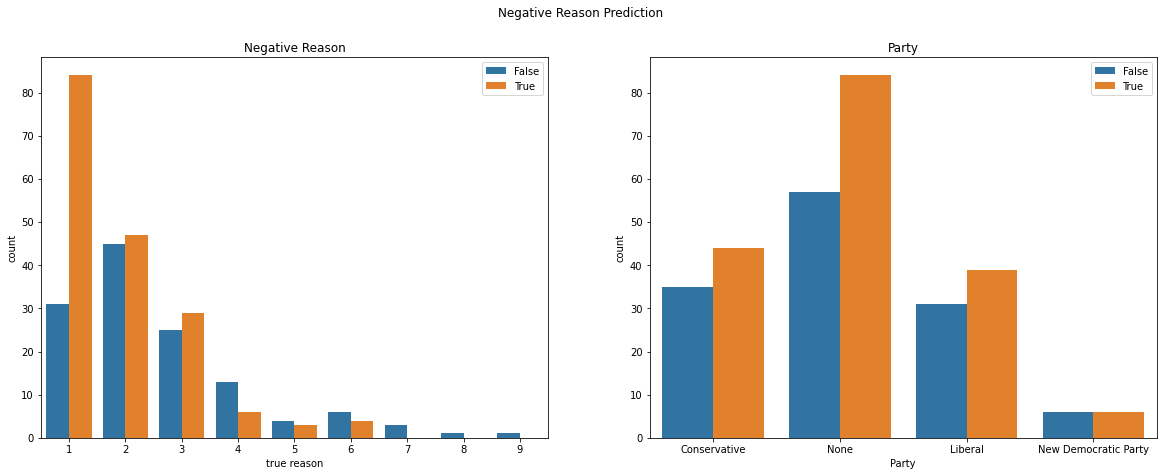

In [87]:
fig1, (ax1, ax2) = plt.subplots(1,2, figsize=(20,7))
tplot=sns.countplot(x='true', hue = 'correct', data=model_result, ax=ax1)
tplot.set(title='Negative Reason', xlabel='true reason')
tplot.legend(loc='upper right')

pplot=sns.countplot(x='party', hue = 'correct', data=model_result,ax=ax2)
pplot.set(title='Party', xlabel='Party')
pplot.legend(loc='upper right')

fig1.suptitle('Negative Reason Prediction')


From the plots above, we can tell correct prediction depends on the number of samples for training. For reasons 1, 2 and 3, tweets correctly predicted are more than tweets wrongly predicted. For reasons 7, 8 and 9, there is no tweet predicted correctly. For prediction results in terms of party, generally the number of negative reasons correctly predicted is more than the number of reasons mispredicted.

- Incorrect prediction could be due to lack of enough tweets for some reasons. Compared with 'Sentiment' which contains more than 130,000 pieces of tweets, the number of tweets in the election dataset is small.
- Apart from lack of tweets, another reason for misprediction could be that words appearing in a training tweet are not very relevant to the true reason of it. Let's look at a tweet that we midpredicted.<br>


In [104]:
model_result.loc[2106]

predict                                                    1
true                                                       4
party                                                   None
text       [wrong, one, using, alberta, punching, bag, pr...
correct                                                False
Name: 2106, dtype: object

This tweet is labelled with reason 4 'Economy', but it is predicted to be 1 'Other'. Let's see what words this tweet contains.

In [105]:
print (election['text'][2106])

['wrong', 'one', 'using', 'alberta', 'punching', 'bag', 'prey', 'local', 'fears', 'telling', 'things', 'get', 'better', 'worship', 'dying', 'industry', 'calgary', 'edmonton', 'trying', 'distance', 'alberta', 'cdnpoli', 'ableg', 'elxn']


Then let's see what words in tweets of reason 4 have high frequency.

In [0]:
train_df=election_negative.loc[y_train_t.index]
r4=train_df[train_df['negative_reason']==4]
r4_list=[]

for i in list(r4.index):
    for w in r4['text'][i]:
        r4_list.append(w)

In [0]:
s = set(r4_list)
count=[]
for w in set(r4_list):
    count.append(r4_list.count(w))
c = pd.DataFrame({'word':list(s), 'count':count})
c.sort_values(by='count', ascending=False).head(20) #show the 20 words appearing most frequently for reason 4

,word,count
90,elxn,34
391,cdnpoli,25
281,pay,10
332,billion,8
71,canadians,8
38,trudeau,8
432,liberal,6
456,one,6
308,money,5
16,canada,5


The words in the tweet [2106] do not really match with the words appearing most frequently in tweets of reason 4. Besides, the words in the tweet have little relation to 'Economy'.

### 5. Suggestion to improve accuracy
1. First model:
Eliminate the neural words as many as possible. There are many neural words such as tags or certain names. Both positive and negative tweets could contain a lot of those words. Excluding those words may help model learn word features better.
2. Second model:
We need more tweet samples. With more input, the model can learn more from word features of different negative reasons, and the model is more likely to make correct prediction based on tweets.

### Explore deep learning algorithms

We can build a neural network to learn from word features and predict negative reasons.

In [64]:
X_train_t.shape

(704, 300)

First, we convert the target variable to binary variables. The negative reason was labelled with integer 1 to 9. Now we convert them to 9 binary variables.

In [0]:
y_dict = {}
for i in range(9):
  y_dict[i+1]=list(np.zeros(y_train_t.shape[0]))
target = pd.DataFrame(y_dict)

In [0]:
for i in range(y_train_t.shape[0]):
  j = y_train_t.iloc[i]-1
  target.iloc[i, j]=1.0  
target=target.set_index(y_train_t.index)

In [109]:
target.head()

,1,2,3,4,5,6,7,8,9
866,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1368,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
797,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
468,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1039,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we create a neural network.

In [0]:
input_dim = X_train_t.shape[1]   #the number of words (dimension) we use to train the model

model = keras.models.Sequential()
model.add(keras.layers.Dense(256, input_shape=(input_dim,), activation='relu'))    #add a layer with 512 neurons and activation function is relu
#model.add(keras.layers.Dense(256, activation='tanh'))    #add a layer with 256 neurons and activation function is tanh
model.add(keras.layers.Dense(128, activation='tanh'))  
model.add(keras.layers.Dense(64, activation='relu'))         
model.add(keras.layers.Dense(16, activation='tanh'))       
model.add(keras.layers.Dense(9, activation='relu'))      #output should have a dimension of 9 to match with target dimension
                                                         #activation function is relu since the target is binary

#train the neural network with 'adam', a combination of stochastic gradient descent ('sgd') and RMS
#train the neural network to minimize 'mean_squared_error' loss
#measure matrics is accuracy

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['accuracy'])



In [107]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 256)               77056     
_________________________________________________________________
dense_35 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_36 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_38 (Dense)             (None, 9)                 153       
Total params: 119,401
Trainable params: 119,401
Non-trainable params: 0
_________________________________________________________________


In [108]:
X_train_t_array = X_train_t.values.astype('float')
y_train_t_array = target.values

batch_size = 16

#verbose=1 to show the progress bar
history=model.fit(X_train_t_array, y_train_t_array,
                    epochs=10,
                    batch_size=16,
                    shuffle=True,
                    verbose=1
               ).history

Train on 704 samples
Epoch 1/10
704/704 [==============================] - 0s 314us/sample - loss: 0.1006 - acc: 0.2969
Epoch 2/10
704/704 [==============================] - 0s 176us/sample - loss: 0.0670 - acc: 0.5639
Epoch 3/10
704/704 [==============================] - 0s 168us/sample - loss: 0.0445 - acc: 0.7401
Epoch 4/10
704/704 [==============================] - 0s 174us/sample - loss: 0.0300 - acc: 0.8324
Epoch 5/10
704/704 [==============================] - 0s 205us/sample - loss: 0.0222 - acc: 0.8594
Epoch 6/10
704/704 [==============================] - 0s 204us/sample - loss: 0.0189 - acc: 0.8651
Epoch 7/10
704/704 [==============================] - 0s 201us/sample - loss: 0.0174 - acc: 0.8679
Epoch 8/10
704/704 [==============================] - 0s 177us/sample - loss: 0.0164 - acc: 0.8707
Epoch 9/10
704/704 [==============================] - 0s 184us/sample - loss: 0.0157 - acc: 0.8722
Epoch 10/10
704/704 [==============================] - 0s 165us/sample - loss: 0.0154 - 

Then we use the trained neural network to predict test data.

In [127]:
X_test_t_array = X_test_t.values.astype('float')
predictions = model.predict(X_test_t)
pred = pd.DataFrame(predictions)
pred.head()

,0,1,2,3,4,5,6,7,8
0,0.714195,0.0,0.006740,0.0,0.0,0.0,0.0,0.0,0.0
1,0.129658,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.413500,0.0,0.280967,0.0,0.0,0.0,0.0,0.0,0.0
3,0.279493,0.0,0.222387,0.0,0.0,0.0,0.0,0.0,0.0
4,0.465520,0.0,0.112889,0.0,0.0,0.0,0.0,0.0,0.0


For a sample, the highest value of the 9 variables indicates which negative reason class the sample belongs to.

In [132]:
pred = pd.DataFrame(predictions)
y_pred = np.array(pred.idxmax(axis=1))+1
y_test = np.array(y_test_t.values)
accuracy = accuracy_score(y_test, y_pred)
print ('accuracy of neural network=',round(accuracy,3))

accuracy of neural network= 0.513


The accuracy of neural network training is 0.513, which is lower than 0.6 the best accuracy of random forest model.